In [124]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

Simulate random variable $X$ with parameter $p$:
- $P(X=k)=p(1-p)^{(k-1)}; k\geq1$

In [159]:
def run_bernoulli(n_success: int, prob_success: float) -> int:
    """Runs a sequence of Bernoulli trials

    Args:
        n_success (int): expected number of successes before stopping trials
        prob_success (float): probability of a success in a single Bernoulli trial

    Returns:
        int: number of trials needed to get the requested number of sucesses
    """
    count_success = 0
    count_trials = 0
    while count_success < n_success:
        bernoulli_trial = np.random.random()
        result = bernoulli_trial < prob_success
        count_success += int(result)
        count_trials += 1
    
    return count_trials

In [171]:
def run_experiment(n_success: int, prob_success: float, n_trials: int, n_repeat: int) -> pl.DataFrame:
    """Runs an experiment consisting of multiple repetitions of Bernoulli Trials
    to determine a statistically relevant sample of histograms representing the
    distribution of the simulated random variable

    Args:
        n_success (int): expected number of successes before stopping trials
        prob_success (float): probability of a success in a single Bernoulli trial
        n_trials (int): number of Bernoulli trials to execute in a sequence
        n_repeat (int): number of repetitions of a series of trials

    Returns:
        pl.DataFrame: history of all executions in a dataframe with the columns
            - trials (int) number of trials to get a success
            - count (int) number of times the success was achievd in this number of trials
            - perc (float) percentage of times the success was achievd in this number of trials
            - repeat (int) id of the repetition
    """
    histograms = list()
    for i in range(n_repeat):
        trials_results = [
            run_bernoulli(n_success=n_success, prob_success=prob_success)
            for _ in range(n_trials)
        ]

        histograms.append(
            pl.Series(values=trials_results, name='trials')
            .value_counts()
            .sort('trials')
            .with_columns(
                perc=pl.col('count') / pl.sum('count'),
                repeat=i,
            )
        )

    return pl.concat(histograms)

In [186]:
prob_success = 0.5

results_simulated = run_experiment(n_success=1, prob_success=prob_success, n_trials=1000, n_repeat=20)

trials_max_sim = results_simulated.select(pl.max('trials')).item()
results_theoretic = [
    prob_success * (1 - prob_success) ** (k - 1)
    for k in range(1, trials_max_sim)
]

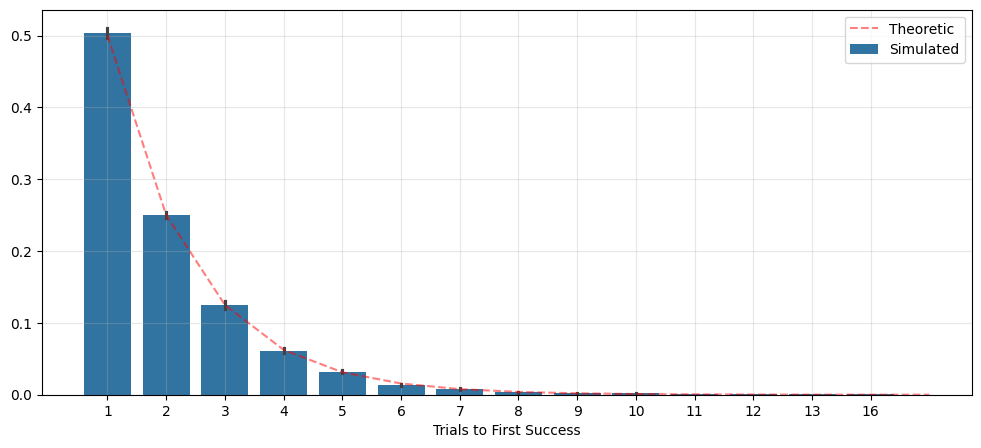

In [193]:
plt.figure(figsize=(12, 5))
ax = plt.gca()

sns.barplot(
    results_simulated,
    x='trials', y='perc',
    errorbar=('ci', 95), n_boot=1000,
    label='Simulated',
    ax=ax,
)

sns.lineplot(
    results_theoretic,
    color='red', ls='--', alpha=0.5,
    label='Theoretic',
    ax=ax,
)

ax.set_xlabel('Trials to First Success')
ax.set_ylabel('')
ax.grid(alpha=0.3)

plt.show()
plt.close()